In [1]:
!pip install transformers


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch 
import torch.optim as optim 
import numpy as np 
import pandas as pd
import random 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader


In [3]:
def set_seeds(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
set_seeds(0)

## 讀檔

In [4]:
df_fake = pd.read_csv('newsData/Fake.csv')['text'].values
df_real = pd.read_csv('newsData/True.csv')['text'].values

datas = np.concatenate((df_fake, df_real), axis = 0).tolist()
labels = df_fake.shape[0] * [0] + df_real.shape[0] * [1]

x_train, x_valid, y_train, y_valid = train_test_split(datas, labels, train_size=0.8, random_state=46, shuffle=True)

In [5]:
tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")

ids = tokenizer(datas[0]).input_ids
tokens = tokenizer.convert_ids_to_tokens(ids)
string = tokenizer.convert_tokens_to_string(tokens)

print('原始文字:\n', datas[0], end = '\n\n')
print('轉換後的文字:\n', string)

Token indices sequence length is longer than the specified maximum sequence length for this model (730 > 512). Running this sequence through the model will result in indexing errors


原始文字:
 Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency wo

## 創建資料集

In [6]:
class News(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

          
    def __getitem__(self, index):
        return self.x[index], self.y[index]
       
    def __len__(self):
        return len(self.x)
    
trainset = News(x_train, y_train)
validset = News(x_valid, y_valid)




In [7]:
def collate_fn(batch):    
    (x, y) = zip(*batch)
    x = tokenizer(x, max_length=512, truncation=True, padding="longest", return_tensors='pt')
    y = {'labels': torch.LongTensor(y)}
    return {**x, **y}

train_loader = DataLoader(trainset, batch_size = 32, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)
valid_loader = DataLoader(validset, batch_size = 32, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity").to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [9]:
def train(epoch):
    train_loss, train_acc = 0, 0
    train_pbar = tqdm(train_loader, position=0, leave=True) # 宣告進度條
    
    model.train() # 將模型切換成訓練模式
    for input_datas in train_pbar: 
        for key in input_datas.keys():
            input_datas[key] = input_datas[key].to(device)
        optimizer.zero_grad()  # 梯度清零
        outputs = model(**input_datas) # 模型計算答案(前向傳播)
        
        logits = outputs.logits
        loss = outputs.loss

        loss.backward() # 返向傳播
        optimizer.step() # 更新模型權重
        
        train_pbar.set_description(f'Train Epoch {epoch}')  # 顯示訓練次數
        train_pbar.set_postfix({'loss':f'{loss:.3f}'}) # 顯示當下模型損失
        
        pred = torch.argmax(logits, dim = 1)
        train_acc += sum(pred == input_datas['labels']) # 計算預測成功的數量
        train_loss += loss.item()  # 模型總損失
    return train_loss/len(train_loader), train_acc/len(trainset) # 計算一次訓練的Loss與準確率


def valid(epoch):
    valid_loss, valid_acc = 0, 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True)
    
    model.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar:
            for key in input_datas.keys():
                input_datas[key] = input_datas[key].to(device)
            
            outputs = model(**input_datas)
            logits = outputs.logits
            loss = outputs.loss
            
            valid_pbar.set_description(f'Valid Epoch {epoch}')
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'})

            pred = torch.argmax(logits, dim = 1)
            valid_acc += sum(pred == input_datas['labels'])
            valid_loss += loss.item()

    return valid_loss/len(valid_loader), valid_acc/len(validset)

        
def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    #標題
    plt.title('Result')
    #y軸標籤
    plt.ylabel('Loss')
    #x軸標籤
    plt.xlabel('Epoch')
    #顯示折線的名稱
    plt.legend(['train', 'valid'], loc='upper left')
    #顯示折線圖
    plt.show()

Valid Epoch 0: 100%|██████████| 281/281 [02:44<00:00,  1.71it/s, loss=0.002]


Saving Model With Acc 0.99833
Train Loss: 0.02403 Train Acc: 0.99387| Valid Loss: 0.00912 Valid Acc: 0.99833| Best Acc: 0.99833



Valid Epoch 1: 100%|██████████| 281/281 [03:02<00:00,  1.54it/s, loss=0.006]


Train Loss: 0.03192 Train Acc: 0.99418| Valid Loss: 0.02761 Valid Acc: 0.99510| Best Acc: 0.99833



Valid Epoch 2: 100%|██████████| 281/281 [03:01<00:00,  1.55it/s, loss=0.238]


Train Loss: 0.03524 Train Acc: 0.99357| Valid Loss: 0.03047 Valid Acc: 0.99454| Best Acc: 0.99833



Valid Epoch 3: 100%|██████████| 281/281 [02:47<00:00,  1.68it/s, loss=0.006]


Train Loss: 0.03610 Train Acc: 0.99337| Valid Loss: 0.03120 Valid Acc: 0.99454| Best Acc: 0.99833



Valid Epoch 4: 100%|██████████| 281/281 [02:59<00:00,  1.56it/s, loss=0.003]

------------------------------------
|Model can't improve, stop training|
------------------------------------


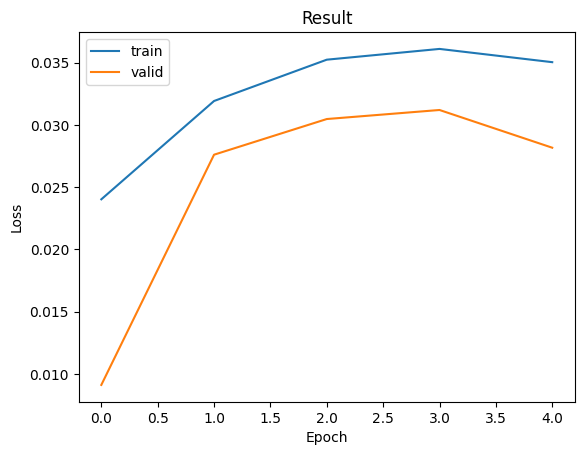

In [10]:
epochs = 10                              # 訓練次數
early_stopping = 4                      # 模型訓練幾次沒進步就停止
stop_cnt = 0                             # 計數模型是否有進步的計數器
model_path = 'model.ckpt'                # 模型存放路徑
show_loss = True                         # 是否顯示訓練折線圖
best_acc = 0                             # 最佳的準確率
loss_record = {'train':[], 'valid':[]}   # 訓練紀錄

for epoch in range(epochs):   
    train_loss, train_acc = train(epoch)
    valid_loss, valid_acc = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # 儲存最佳的模型權重
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print(f'Saving Model With Acc {best_acc:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break

    print(f'Train Loss: {train_loss:.5f} Train Acc: {train_acc:.5f}', end='| ')
    print(f'Valid Loss: {valid_loss:.5f} Valid Acc: {valid_acc:.5f}', end='| ')
    print(f'Best Acc: {best_acc:.5f}', end='\n\n')

if show_loss:
    show_training_loss(loss_record)
        

In [11]:
model.load_state_dict(torch.load(modcel_path))
model.eval()

NameError: name 'modcel_path' is not defined